
Demonstrate the usage of the basic functions.

@author: Guihong Wan and Boshen Yan      
@date: July 20, 2023

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import anndata as ad
import statistics

In [2]:
import spatialcells as spc

In [3]:
print(ad.__version__)
print(spc.__version__)

0.9.1
0.9.2


In [4]:
np.random.seed(42)

# Read data

In [7]:
adata = ad.read('../../data/example_adata.h5ad')
adata.obs["id"] = adata.obs_names

# Gate

In [9]:
adata.raw.X

array([[ 576.66666667,  368.83060109,  226.85245902, ...,   71.22404372,
         650.70491803,  130.3715847 ],
       [ 784.94202899,  473.91304348,  431.33333333, ...,   75.08695652,
        8975.43478261,  139.72463768],
       [ 761.28333333,  424.85      ,  274.33333333, ...,   80.1       ,
         762.48333333,  134.3       ],
       ...,
       [ 555.56790123,  532.79012346,  420.59259259, ...,  194.35802469,
         787.62962963,  132.14814815],
       [ 312.07317073,  484.24390244,  406.80487805, ...,  139.68292683,
         740.75609756,  125.17073171],
       [ 634.84415584,  558.7012987 ,  459.06493506, ...,  308.4025974 ,
         782.23376623,  129.87012987]])

In [10]:
adata

AnnData object with n_obs × n_vars = 137816 × 7
    obs: 'X_centroid', 'Y_centroid', 'id'
    uns: 'all_markers'

In [11]:
print(list(adata.var_names))

['SOX10', 'CD8A', 'CD3E', 'CD45', 'panCK', 'CD4', 'aSMA']


# setGate or setGates

Run here if your data is not gated.

In [12]:
# New columns, SOX10_positive and CD45_positive, will be added
spc.prep.setGate(adata, "SOX10", 7.5, debug = True)
spc.prep.setGate(adata, "CD45", 8.0, debug = True)

SOX10_positive
False    91523
True     46293
Name: count, dtype: int64
CD45_positive
False    98518
True     39298
Name: count, dtype: int64


In [14]:
# A column ending with "_positive" for each marker will be added
gate_file = "../../data/example_gates.csv"
spc.prep.setGates(adata, gate_file, debug = True)

gate: 7.5 SOX10_positive
False    91523
True     46293
Name: count, dtype: int64
gate: 7.0 CD8A_positive
False    116836
True      20980
Name: count, dtype: int64
gate: 7.2 CD3E_positive
False    111855
True      25961
Name: count, dtype: int64
gate: 8.0 CD45_positive
False    98518
True     39298
Name: count, dtype: int64
gate: 6.5 panCK_positive
False    129174
True       8642
Name: count, dtype: int64
gate: 7.4 CD4_positive
False    113595
True      24221
Name: count, dtype: int64
gate: 5.7 aSMA_positive
False    129847
True       7969
Name: count, dtype: int64


In [15]:
adata

AnnData object with n_obs × n_vars = 137816 × 7
    obs: 'X_centroid', 'Y_centroid', 'id', 'SOX10_positive', 'CD45_positive', 'CD8A_positive', 'CD3E_positive', 'panCK_positive', 'CD4_positive', 'aSMA_positive'
    uns: 'all_markers'

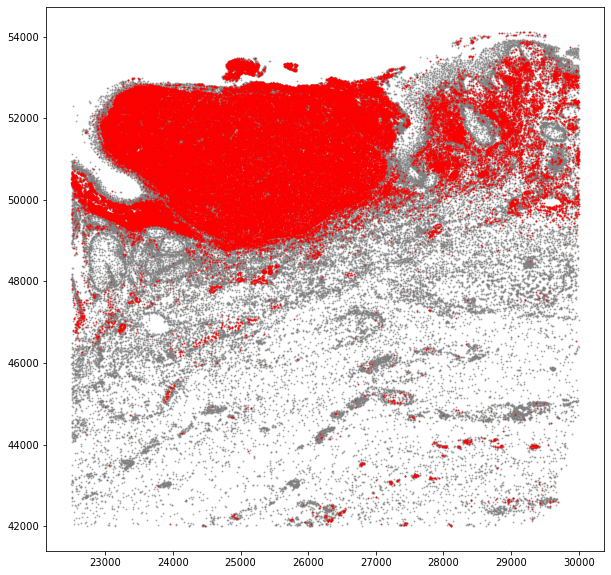

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))

## all points
ax.scatter(*zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=1, color="grey", alpha=0.5)

## SOX10+ cells
tmp = adata[adata.obs.SOX10_positive]
ax.scatter(*zip(*tmp.obs[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=1, color="red", alpha=0.5)

## CD45+ cells
tmp = adata[adata.obs.CD45_positive]
ax.scatter(*zip(*tmp.obs[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=1, color="red", alpha=0.5)

plt.show()

The following steps compute the communities based on SOX10+ or CD45+ cells.

In [17]:
markders_of_interest = ["SOX10_positive","CD45_positive"]

# estimateInitialDistance

In [18]:
# Downsampling is desired; otherwise slow
# Use to estimate the eps parameter for getCommunities()

# distance_candidates = spc.spatial.estimateInitialDistance(adata, 
#                                               markders_of_interest, 
#                                               sampling_ratio=0.3)
# print(statistics.quantiles(distance_candidates))

# getCommunities

In [19]:
# %%timeit -r1 -n10
communitycolumn = "COI_community"
ret = spc.spatial.getCommunities(adata, markders_of_interest, 
                                 eps= 100, 
                                 newcolumn = communitycolumn)


In [20]:
print("number of communiteis:", len(ret[0]))
# print(adata.obs[communitycolumn].value_counts())

number of communiteis: 26


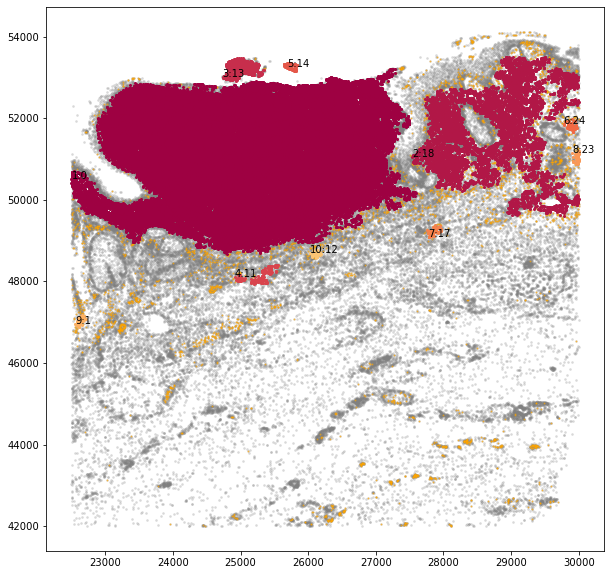

In [21]:
# input: output of getCommunities()
markersize = 2

labels_sorted = ret[0]
db = ret[1]
plot_first_n_clusters = 10

adata_tmp = adata[adata.obs[communitycolumn] > -2]
X = adata_tmp.obs[["X_centroid", "Y_centroid"]].to_numpy()
labels = db.labels_
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

fig, ax = plt.subplots(figsize=(10, 10))

## all points
ax.scatter(*zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=3, color="grey", alpha=0.2)

# Points of interest: outliers
ax.scatter(X[:,0], X[:,1], alpha=0.5, color="orange", s=markersize/2)

# clusters
idx = 0
for npoints, k in labels_sorted:
    if k == -1:
        continue
    if idx >= plot_first_n_clusters:
        break
        
    col = colors[idx] 
    class_member_mask = labels == k
    mask = class_member_mask & core_samples_mask
    xy = X[mask]
    plt.plot(xy[:, 0],xy[:, 1],
             "o",
             markerfacecolor=tuple(col),
             markeredgecolor=tuple(col),
             markersize=markersize,
            )
    # idx: the "idx" largest cluster
    # k: the cluster
    plt.annotate(str(idx+1)+":"+str(k), (xy[0, 0], xy[0, 1]))

    idx += 1

plt.show()
 

In [22]:
clusters_idx_sorted = [idx for npoints, idx in ret[0]]
print(clusters_idx_sorted[:plot_first_n_clusters])
print(ret[0][:plot_first_n_clusters])

[0, 18, 13, 11, 14, 24, 17, 23, 1, 12]
[(68743, 0), (8580, 18), (1222, 13), (217, 11), (161, 14), (97, 24), (75, 17), (67, 23), (62, 1), (59, 12)]


In [23]:
# Here we choose the three largest ones of interest
communityIndexList = [0]

# getBoundary    

In [27]:
import importlib
import _utils
import _getBoundary
import _getExtendedBoundary
import _getShrunkenBoundary

In [28]:
importlib.reload(_utils)
importlib.reload(_getBoundary)

from _getBoundary import getBoundary
from _utils import *

boundaries, boundaries_components = getBoundary(adata, 
                         communitycolumn, communityIndexList,
                         alpha=60,# smaller, more detailed the edges are
                         nedges_min = 20, # the minimum number of edges of a component inside a bigger component.
                         nedges_out_min = 20) # the minimumn number of edges of a component to be an outside component.


In [29]:
print("#edges:", boundaries.shape[0])
print("#components:", len(boundaries_components))

#edges: 479
#components: 1


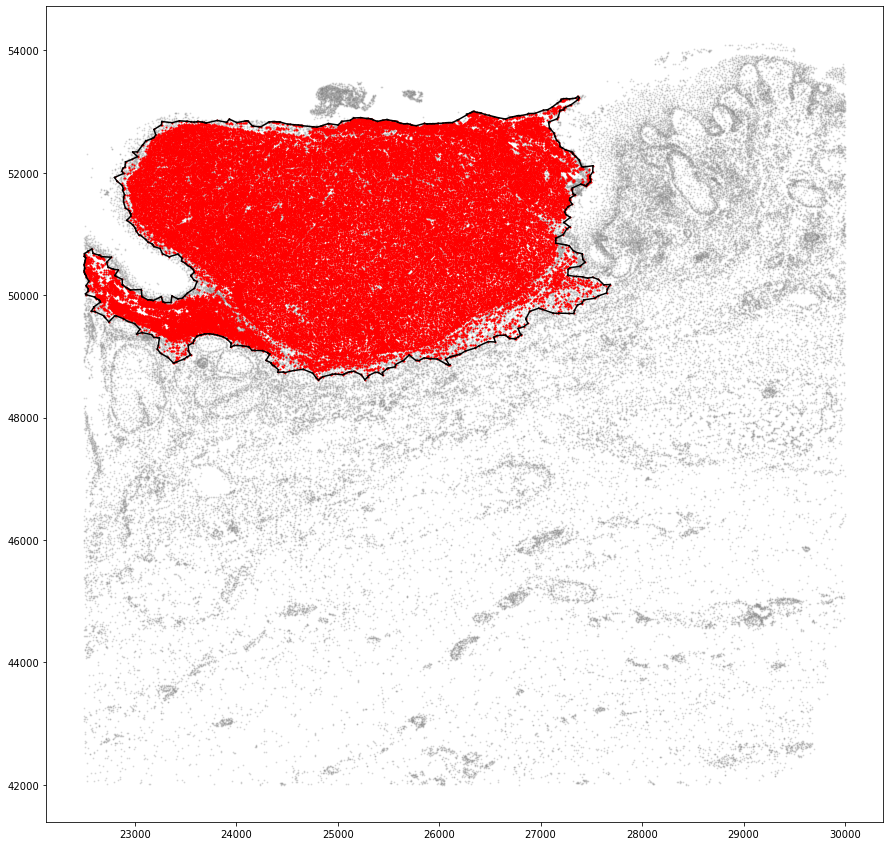

In [30]:
# all rings, including touching ones

markersize = 1

fig, ax = plt.subplots(figsize=(15, 15))

## all points
ax.scatter(*zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=markersize, color="grey", alpha=0.2)

# Points in selected commnities
xy = adata.obs[adata.obs[communitycolumn].isin(communityIndexList)][
        ["X_centroid", "Y_centroid"]
    ].to_numpy()
ax.scatter(xy[:,0], xy[:,1], s=markersize, color="r")

# Bounds of points in selected commnities
for edge in boundaries:
    ax.plot(edge[:, 0], edge[:, 1], color="k")

plt.show()

# getExtendedBoundary     
# getShrunkenBoundary

In [31]:
# # additional internal boundary rings for testing
# p1 = (25000, 50000)
# p2 = (24500, 51000)
# p3 = (25000, 52000)
# p4 = (25500, 51000)
# p5 = (26500, 50000)
# p6 = (26000, 51000)
# p7 = (26500, 52000)
# p8 = (27000, 51000)
# fake_edge1 = np.array(
#     [
#         [p1, p2],
#         [p2, p3],
#         [p3, p4],
#         [p4, p1]
#     ]
# )
# fake_edge2 = np.array(
#     [
#         [p5, p6],
#         [p6, p7],
#         [p7, p8],
#         [p8, p5]
#     ]
# )

# boundaries[0].extend([fake_edge1, fake_edge2])
# boundaries_edge = getEdgesOnBoundary(boundaries)
# boundaries_polygon = getPolygons(boundaries)

In [32]:
importlib.reload(_utils)
importlib.reload(_getShrunkenBoundary)
importlib.reload(_getExtendedBoundary)

from _utils import *
from _getShrunkenBoundary import *
from _getExtendedBoundary import *

# Remove backgroud. Anything beyong this will not be considered
ROI_boundaries, ROI_boundary_components = getExtendedBoundary(
    boundaries_components, offset=1000, minsize=20
)

shrunken_boundaries, shrunken_boundary_components = getShrunkenBoundary(
    boundaries_components, offset=100, minsize=20
)


extended_boundaries, extended_boundary_components = getExtendedBoundary(
    boundaries_components, offset=100, minsize=20
)

print(len(shrunken_boundary_components[0]))
print(len(extended_boundary_components[0]))

1
1


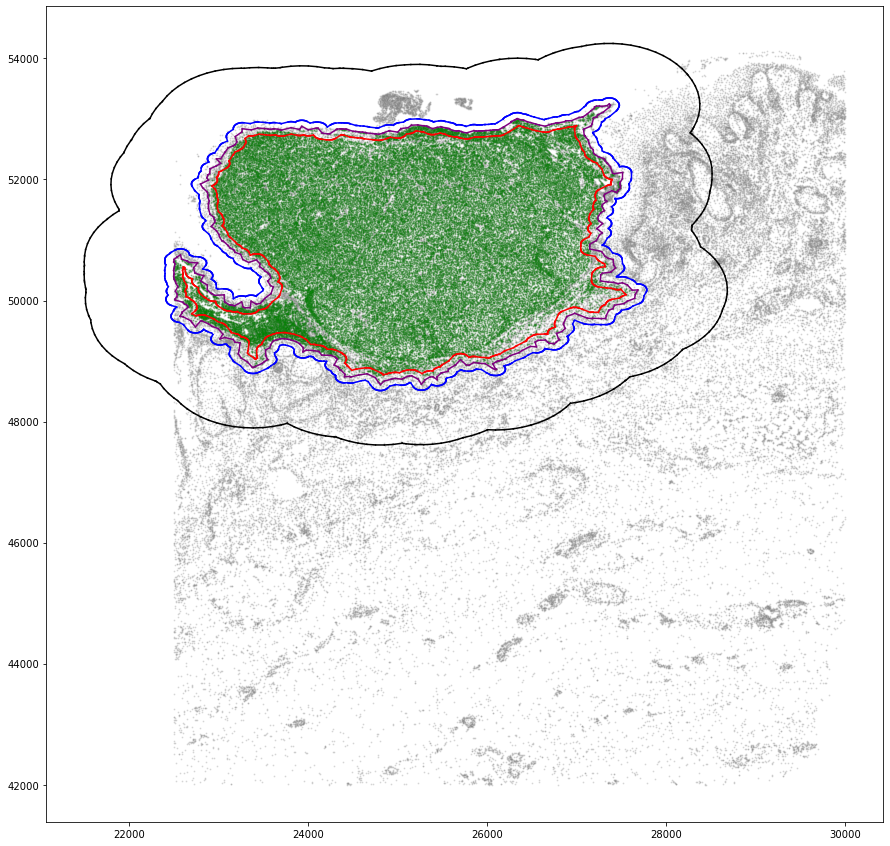

In [33]:
pointsize = 1
fig, ax = plt.subplots(figsize=(15, 15))

## all points
ax.scatter(*zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=markersize, color="grey", alpha=0.2)

# Points in selected commnities
xy = adata.obs[adata.obs[communitycolumn].isin(communityIndexList)][
        ["X_centroid", "Y_centroid"]
    ].to_numpy()
ax.scatter(xy[:,0], xy[:,1], s=markersize, color="green", alpha=0.2)

# Bounds of points in selected commnities
for ed in boundaries:
    ax.plot(ed[:, 0], ed[:, 1], color="purple")


for ed in ROI_boundaries:
    ax.plot(ed[:, 0], ed[:, 1], color="k")
    
for ed in shrunken_boundaries:
    ax.plot(ed[:, 0], ed[:, 1], color="red")

for ed in extended_boundaries:
    ax.plot(ed[:, 0], ed[:, 1], color="blue")
plt.show()


# assignPointsToRegion

In [34]:
import _assignPointsToRegion

In [35]:
# shrunken_boundary_components
# boundaries_components
# extended_boundaries

In [36]:
regions = ["0In", "1Bi", "2Bo", "3Out", "BG"]
adata.obs["region"] = "BG"
adata.obs["region"] = pd.Categorical(adata.obs["region"], categories=regions, ordered=True)

In [ ]:
importlib.reload(_utils)
importlib.reload(_assignPointsToRegion)

from _utils import *
from _assignPointsToRegion import assignPointsToRegion

# 0In
target = "0In"
donelist = [target]
_ = assignPointsToRegion(adata, shrunken_boundary_components,
                     assigncolumn = "region",
                     target=target, donelist=donelist)


Assigning a region for each cell...


In [ ]:
# 1Bi
target = "1Bi"
donelist = ["0In", target]

xv, yv, grid_label = assignPointsToRegion(adata, boundaries_components,
                     assigncolumn = "region",
                     target=target, donelist=donelist)

In [ ]:
# 2Bo
target = "2Bo"
donelist = ["0In", "1Bi", target]

xv, yv, grid_label = assignPointsToRegion(adata, extended_boundary_components,
                     assigncolumn = "region",
                     target=target, donelist=donelist)

In [ ]:
# 3Out
target = "3Out"
donelist = ["0In", "1Bi", "2Bo", target]

xv, yv, grid_label = assignPointsToRegion(adata, ROI_boundary_components,
                     assigncolumn = "region",
                     target=target, donelist=donelist)

In [ ]:
print(set(adata.obs['region']))
print(adata.obs['region'].value_counts())

In [ ]:
# import seaborn as sns

# sns.lmplot('X_centroid', 'Y_centroid', data=adata.obs, hue='region', fit_reg=False)

point_size = 1
fig, ax = plt.subplots(figsize=(15, 15))

for region in sorted(set(adata.obs['region'])):
    tmp = adata[adata.obs.region==region]
    ax.scatter(*zip(*tmp.obs[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=point_size, alpha=0.7, label = region)

# Bounds of points in selected commnities
for ed in boundaries:
    ax.plot(ed[:, 0], ed[:, 1], color="purple")


for ed in ROI_boundaries:
    ax.plot(ed[:, 0], ed[:, 1], color="k")
    
for ed in shrunken_boundaries:
    ax.plot(ed[:, 0], ed[:, 1], color="red")

for ed in extended_boundaries:
    ax.plot(ed[:, 0], ed[:, 1], color="blue")

    
# plt.xlim(23000, 25000)
# plt.ylim(50000, 52000)

plt.legend(loc="lower left", markerscale=10, fontsize=20)
plt.show()